# LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pkgutil
search_path = ['drive/My Drive/Colab Notebooks/'] # set to None to see all modules importable from sys.path
all_modules = [x[1] for x in pkgutil.iter_modules(path=search_path)]
print(all_modules)

['fcn_vgg16']


## Text preparation 

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def replace_abbreviations(text):
    texts = []
    for item in text:
        item = item.lower().replace("it's", "it is").replace("i'm", "i am").replace("he's", "he is").replace("she's", "she is")\
            .replace("we're", "we are").replace("they're", "they are").replace("you're", "you are").replace("that's", "that is")\
            .replace("this's", "this is").replace("can't", "can not").replace("don't", "do not").replace("doesn't", "does not")\
            .replace("we've", "we have").replace("i've", " i have").replace("isn't", "is not").replace("won't", "will not")\
            .replace("hasn't", "has not").replace("wasn't", "was not").replace("weren't", "were not").replace("let's", "let us")\
            .replace("didn't", "did not").replace("hadn't", "had not").replace("waht's", "what is").replace("couldn't", "could not")\
            .replace("you'll", "you will").replace("you've", "you have")
        item = item.replace("'s", "")
        texts.append(item)
    return texts

def stemed_words(text):
    stop_words = stopwords.words("english")
    lemma = WordNetLemmatizer()
    texts = []
    for item in text:
        words = [lemma.lemmatize(w, pos='v') for w in item.split() if w not in stop_words]
        texts.append(" ".join(words))
    return texts

def preprocess(text):
    text = replace_abbreviations(text)
    text = stemed_words(text)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
'''
from wordcloud import WordCloud
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 2000,
        height = 1500,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
'''

"\nfrom wordcloud import WordCloud\nfrom matplotlib import rcParams\nimport matplotlib.pyplot as plt\nimport seaborn as sns\ndef generate_word_cloud(text):\n    wordcloud = WordCloud(\n        width = 2000,\n        height = 1500,\n        background_color = 'black').generate(str(text))\n    fig = plt.figure(\n        figsize = (40, 30),\n        facecolor = 'k',\n        edgecolor = 'k')\n    plt.imshow(wordcloud, interpolation = 'bilinear')\n    plt.axis('off')\n    plt.tight_layout(pad=0)\n    plt.show()\n"

In [ ]:
import gensim


def trainWord2Vec(filePath):
    sentences =  gensim.models.word2vec.LineSentence(filePath) 
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=1, workers=4) 

    model.save('./CarComment_vord2vec_100')


def testMyWord2Vec():
    inp = './CarComment_vord2vec_100'  
    model = gensim.models.Word2Vec.load(inp)

    print('word2vec）:',model['vector'])
    print('print：',model.most_similar('vector', topn=5))

You can read all the ground truth captions (5 per image), into memory as follows:

In [ ]:
embed_size = 256
max_features = 2000

def get_lstm_model(max_features, embed_size):
    model = Sequential()
    model.add(Embedding(max_features, embed_size))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    
    return model


def model_fit(model, x, y):
    return model.fit(x, y, batch_size=100, epochs=3, validation_split=0.1)

def model_predict(model, x):
    return model.predict_classes(x)

### TASK A

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

import pandas as pd
root = '/content/drive/My Drive/Colab Notebooks/data/OLID/'

train_df = pd.read_csv(root+'training.csv')

train_texts = preprocess(train_df['tweet'])
#train_texts = train_df['tweet']
#generate_word_cloud(train_texts)
test_df = pd.read_csv(root+'testset-levela.csv')
test_texts = preprocess(test_df['tweet'])
#test_texts = test_df['tweet']
y_test = np.array([0 if x == 'NOT' else 1 for x in test_df['label']])

tok = Tokenizer(num_words=max_features)
texts = train_texts+test_texts
tok.fit_on_texts(texts)
list_tok = tok.texts_to_sequences(texts)

seq_tok = pad_sequences(list_tok, maxlen=None)

x_train = seq_tok[:len(train_texts)]
y_train = np.array([0 if x == 'NOT' else 1 for x in train_df['subtask_a']])

x_test = seq_tok[len(train_texts):]
y_test = np.array([0 if x == 'NOT' else 1 for x in test_df['label']])


In [ ]:
embed_size = 256
max_features = 2000

def get_lstm_model(max_features, embed_size):
    model = Sequential()
    model.add(Embedding(2000, 256, input_length=10))

    input_array = np.random.randint(2000, size=(32, 10))

    model.compile('rmsprop', 'mse')
    output_array = model.predict(input_array)
    assert output_array.shape == (32, 10, 64)


In [ ]:
import matplotlib.pyplot as plt

model = get_lstm_model(max_features, embed_size)
model_train = model.fit(x_train,y_train, batch_size=100, epochs=4, validation_split=0.01)


AssertionError: ignored

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


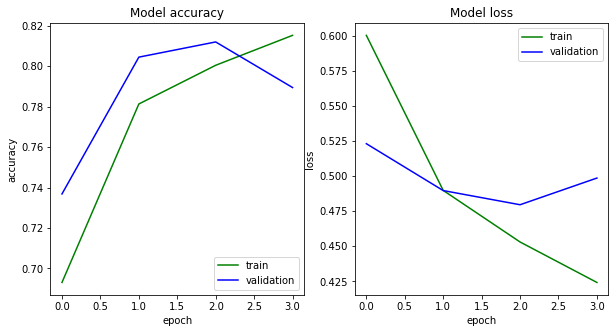

0.7930232558139535
0.9032258064516129
0.5083333333333333


In [ ]:
y_pred = model_predict(model, x_test)

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(model_train.history['acc'], c='g', label='train')
plt.plot(model_train.history['val_acc'], c='b', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model accuracy')

plt.subplot(122)
plt.plot(model_train.history['loss'], c='g', label='train')
plt.plot(model_train.history['val_loss'], c='b', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model loss')

plt.show()



count = 0
count_off1 = 0
count_not1 = 0
count_off2 = 0
count_not2 = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        count += 1
    if y_test[i] == 0:
        count_not1 +=1
        if y_test[i] == y_pred[i]:
            count_not2 +=1
    else:
        count_off1 += 1
        if y_test[i] == y_pred[i]:
            count_off2 +=1
        
        
print(count/len(y_test))
print(count_not2/count_not1)
print(count_off2/count_off1)



ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

def plot_roc(labels, predict_prob):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

Accuracy 0.7930232558139535
Precision [0.8259587  0.67032967]
Recall [0.90322581 0.50833333]
f1_score [0.86286595 0.57819905]
f1_score(macro) 0.7205324998722058
f1_score(micro) 0.7930232558139535
f1_score(weight) 0.7834240232919868
MCC 0.45194249150525684
confusion_matrix
[[560  60]
 [118 122]]


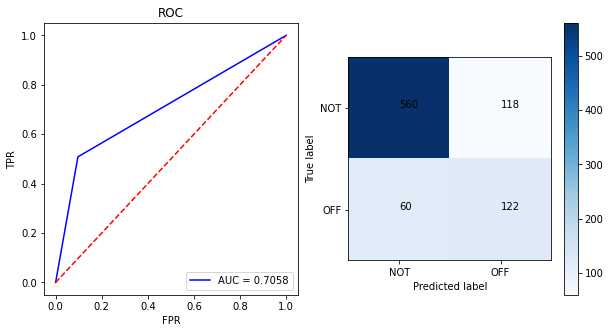

In [ ]:
import sklearn as sk

print("Accuracy", sk.metrics.accuracy_score(y_test, y_pred))
print("Precision", sk.metrics.precision_score(y_test, y_pred, average=None))
print( "Recall", sk.metrics.recall_score(y_test, y_pred, average=None))
print( "f1_score", sk.metrics.f1_score(y_test, y_pred, average=None))
print( "f1_score(macro)", sk.metrics.f1_score(y_test, y_pred, average='macro'))
print( "f1_score(micro)", sk.metrics.f1_score(y_test, y_pred, average='micro'))
print( "f1_score(weight)", sk.metrics.f1_score(y_test, y_pred, average='weighted'))
print( "MCC", sk.metrics.matthews_corrcoef(y_test, y_pred, sample_weight=None))
print( "confusion_matrix")
'''
plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_roc(y_test, y_pred)

print( sk.metrics.confusion_matrix(y_test, y_pred))

confusion =  sk.metrics.confusion_matrix(y_test, y_pred)

guess = ['NOT', 'OFF']
fact = ['NOT', 'OFF']
classes = list(set(fact))
classes.sort()

plt.subplot(122)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
'''

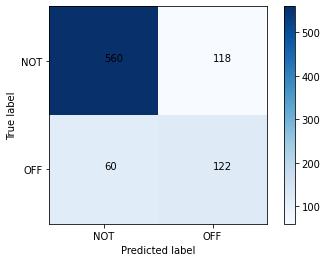

In [ ]:
guess = ['NOT', 'OFF']
fact = ['NOT', 'OFF']
classes = list(set(fact))
classes.sort()
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])
 


### TASK B

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

root = '/content/drive/My Drive/Colab Notebooks/data/OLID/'

#train_df = pd.read_csv(root+'training.csv')
train_texts = preprocess(train_df['tweet'])
#print(train_df)
#test_df = pd.read_csv(root+'testset-levelb.csv')
test_texts = preprocess(test_df['tweet'])

tok = Tokenizer(num_words=max_features)
texts = train_texts+test_texts
#texts = train_df + test_df
tok.fit_on_texts(texts)
list_tok = tok.texts_to_sequences(texts)

seq_tok = pad_sequences(list_tok, maxlen=None)

x_train = seq_tok[:len(train_texts)]
y_train = np.array([0 if x == 'TIN' else 1 for x in train_df['sbutask_b']])

x_test = seq_tok[len(train_texts):]
y_test = np.array([0 if x == 'TIN' else 1 for x in test_df['label']])

'''
x_train = seq_tok[:len(train_df)]
y_train = np.array([0 if x == 'TIN' else 1 for x in train_df['sbutask_b']])

x_test = seq_tok[len(train_df):]
y_test = np.array([0 if x == 'TIN' else 1 for x in test_df['label']])
'''

"\nx_train = seq_tok[:len(train_df)]\ny_train = np.array([0 if x == 'TIN' else 1 for x in train_df['sbutask_b']])\n\nx_test = seq_tok[len(train_df):]\ny_test = np.array([0 if x == 'TIN' else 1 for x in test_df['label']])\n"

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 256)         512000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 590,274
Trainable params: 590,274
Non-trainable params: 0
________________________________________________

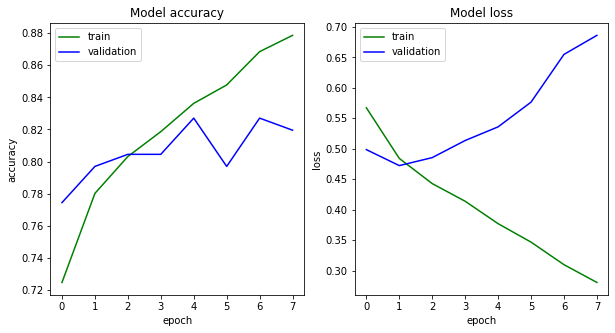

0.4125


In [ ]:
import matplotlib.pyplot as plt

model = get_lstm_model(max_features, embed_size)
model_train = model.fit(x_train,y_train, batch_size=50, epochs=8, validation_split=0.01)
y_pred = model_predict(model, x_test)

'''
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(model_train.history['acc'], c='g', label='train')
plt.plot(model_train.history['val_acc'], c='b', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model accuracy')

plt.subplot(122)
plt.plot(model_train.history['loss'], c='g', label='train')
plt.plot(model_train.history['val_loss'], c='b', label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model loss')

plt.show()
'''

count = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        count += 1
print(count/len(y_test))

Accuracy 0.4125
Precision [0.82727273 0.06153846]
Recall [0.42723005 0.2962963 ]
f1_score [0.56346749 0.10191083]
f1_score(macro) 0.33268916014276984
f1_score(micro) 0.4125
f1_score(weight) 0.5115423675336712
MCC -0.17533048000747176
confusion_matrix
[[ 91 122]
 [ 19   8]]


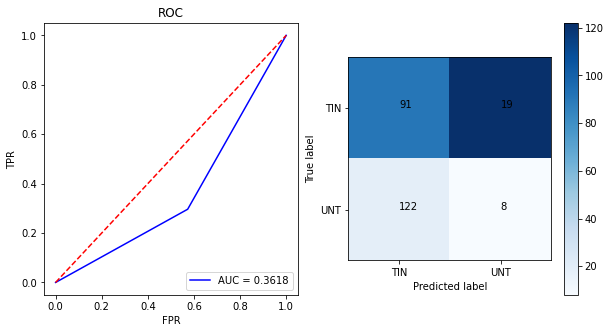

In [ ]:
import sklearn as sk
y_pred = model_predict(model, x_test)

        
print("Accuracy", sk.metrics.accuracy_score(y_test, y_pred))
print("Precision", sk.metrics.precision_score(y_test, y_pred, average=None))
print( "Recall", sk.metrics.recall_score(y_test, y_pred, average=None))
print( "f1_score", sk.metrics.f1_score(y_test, y_pred, average=None))
print( "f1_score(macro)", sk.metrics.f1_score(y_test, y_pred, average='macro'))
print( "f1_score(micro)", sk.metrics.f1_score(y_test, y_pred, average='micro'))
print( "f1_score(weight)", sk.metrics.f1_score(y_test, y_pred, average='weighted'))
print( "MCC", sk.metrics.matthews_corrcoef(y_test, y_pred, sample_weight=None))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_roc(y_test, y_pred)

print( "confusion_matrix")
print( sk.metrics.confusion_matrix(y_test, y_pred))

confusion =  sk.metrics.confusion_matrix(y_test, y_pred)

guess = ['TIN', 'UNT']
fact = ['TIN', 'UNT']
classes = list(set(fact))
classes.sort()

plt.subplot(122)
plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])

### TASK C

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer

train_df = pd.read_csv(root+'training.csv')
train_texts = preprocess(train_df['tweet'])

test_df = pd.read_csv(root+'testset-levelc.csv')
test_texts = preprocess(test_df['tweet'])

tok = Tokenizer(num_words=max_features)
texts = train_texts+test_texts
tok.fit_on_texts(texts)
list_tok = tok.texts_to_sequences(texts)

seq_tok = pad_sequences(list_tok, maxlen=None)

x_train = seq_tok[:len(train_texts)]
y_train = []
for x in train_df['subtask_c']:
    if x == 'IND': y = 0
    elif x == 'OTH': y = 1 
    else: y = 2
    y_train.append(y)
y_train = np.array(y_train)

x_test = seq_tok[len(train_texts):]

y_test = []
for x in test_df['label']:
    if x == 'IND': y = 0
    elif x == 'OTH': y = 1 
    else: y = 2
    y_test.append(y)
y_test = np.array(y_test)

print(y_train)

[2 0 2 ... 1 2 2]


In [ ]:
import matplotlib.pyplot as plt

model = get_lstm_model(max_features, embed_size)
model.fit(x_train,y_train, batch_size=100, epochs=5, validation_split=0.01)

count = 0
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        count += 1
print(count/len(y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         512000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                73984     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 590,274
Trainable params: 590,274
Non-trainable params: 0
________________________________________________

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl  
import matplotlib.pyplot as plt

def plot_roc(labels, predict_prob):
    #false_positive_rate,true_positive_rate,thresholds=roc_curve(labels, predict_prob)
    #roc_auc=auc(false_positive_rate, true_positive_rate, average='macro')
    fpr = dict() 
    tpr = dict() 
    roc_auc = dict() 
    for i in range(1): 
      fpr[i], tpr[i], _ = roc_curve(labels[:, i], predict_prob[:, i]) 
      roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(labels.ravel(), predict_prob.ravel()) 
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')

Accuracy 0.4694835680751174
Precision [0.46948357 0.         0.        ]
Recall [1. 0. 0.]
f1_score [0.63897764 0.         0.        ]
f1_score(macro) 0.21299254526091585
f1_score(micro) 0.4694835680751174
f1_score(weight) 0.2999895003674871
confusion_matrix
[[100   0   0]
 [ 35   0   0]
 [ 78   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


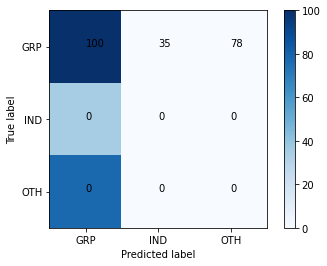

In [ ]:
import sklearn as sk
y_pred = model_predict(model, x_test)

        
print("Accuracy", sk.metrics.accuracy_score(y_test, y_pred))
print("Precision", sk.metrics.precision_score(y_test, y_pred, average=None))
print( "Recall", sk.metrics.recall_score(y_test, y_pred, average=None))
print( "f1_score", sk.metrics.f1_score(y_test, y_pred, average=None))
print( "f1_score(macro)", sk.metrics.f1_score(y_test, y_pred, average='macro'))
print( "f1_score(micro)", sk.metrics.f1_score(y_test, y_pred, average='micro'))
print( "f1_score(weight)", sk.metrics.f1_score(y_test, y_pred, average='weighted'))

print( "confusion_matrix")
print( sk.metrics.confusion_matrix(y_test, y_pred))
confusion =  sk.metrics.confusion_matrix(y_test, y_pred)

guess = ['IND', 'OTH', 'GRP']
fact = ['IND', 'OTH', 'GRP']
classes = list(set(fact))
classes.sort()

plt.imshow(confusion, cmap=plt.cm.Blues)
indices = range(len(confusion))
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index])